<a href="https://colab.research.google.com/github/PavankumarUppar/Self_Driving_Car/blob/main/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/PavankumarUppar/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [ ]:
!ls Track

driving_log.csv  IMG


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

In [ ]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-25-d963de388c8a>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,D:\Self Driving Car\Data\IMG\center_2023_09_01_19_03_16_732.jpg,D:\Self Driving Car\Data\IMG\left_2023_09_01_19_03_16_732.jpg,D:\Self Driving Car\Data\IMG\right_2023_09_01_19_03_16_732.jpg,0.0,0.0,0,0.000003
1,D:\Self Driving Car\Data\IMG\center_2023_09_01_19_03_16_800.jpg,D:\Self Driving Car\Data\IMG\left_2023_09_01_19_03_16_800.jpg,D:\Self Driving Car\Data\IMG\right_2023_09_01_19_03_16_800.jpg,0.0,0.0,0,0.000003
2,D:\Self Driving Car\Data\IMG\center_2023_09_01_19_03_16_875.jpg,D:\Self Driving Car\Data\IMG\left_2023_09_01_19_03_16_875.jpg,D:\Self Driving Car\Data\IMG\right_2023_09_01_19_03_16_875.jpg,0.0,0.0,0,0.000004
3,D:\Self Driving Car\Data\IMG\center_2023_09_01_19_03_16_949.jpg,D:\Self Driving Car\Data\IMG\left_2023_09_01_19_03_16_949.jpg,D:\Self Driving Car\Data\IMG\right_2023_09_01_19_03_16_949.jpg,0.0,0.0,0,0.000012
4,D:\Self Driving Car\Data\IMG\center_2023_09_01_19_03_17_021.jpg,D:\Self Driving Car\Data\IMG\left_2023_09_01_19_03_17_021.jpg,D:\Self Driving Car\Data\IMG\right_2023_09_01_19_03_17_021.jpg,0.0,0.0,0,0.000013


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_09_01_19_03_16_732.jpg,left_2023_09_01_19_03_16_732.jpg,right_2023_09_01_19_03_16_732.jpg,0.0,0.0,0,0.000003
1,center_2023_09_01_19_03_16_800.jpg,left_2023_09_01_19_03_16_800.jpg,right_2023_09_01_19_03_16_800.jpg,0.0,0.0,0,0.000003
2,center_2023_09_01_19_03_16_875.jpg,left_2023_09_01_19_03_16_875.jpg,right_2023_09_01_19_03_16_875.jpg,0.0,0.0,0,0.000004
3,center_2023_09_01_19_03_16_949.jpg,left_2023_09_01_19_03_16_949.jpg,right_2023_09_01_19_03_16_949.jpg,0.0,0.0,0,0.000012
4,center_2023_09_01_19_03_17_021.jpg,left_2023_09_01_19_03_17_021.jpg,right_2023_09_01_19_03_17_021.jpg,0.0,0.0,0,0.000013


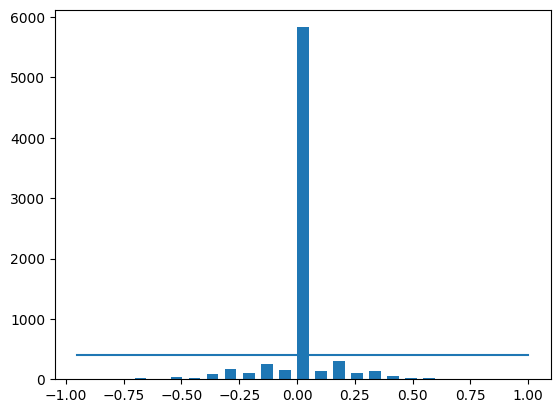

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
#print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data 7507
removed:  5432
remaining:  2075


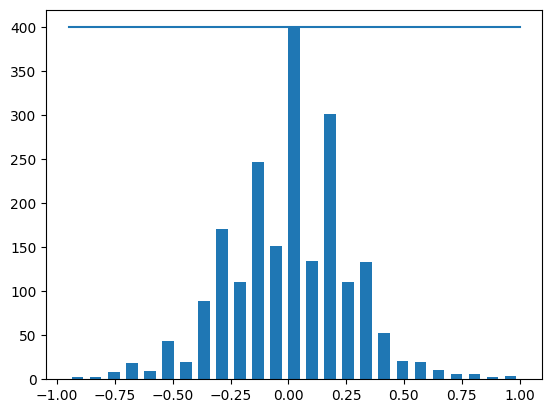

In [ ]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steering = load_img_steering(datadir + '/IMG', data)

center      center_2023_09_01_19_03_17_744.jpg
left        left_2023_09_01_19_03_17_744.jpg  
right       right_2023_09_01_19_03_17_744.jpg 
steering   -0.3                               
throttle    1.0                               
reverse     0                                 
speed       6.069761                          
Name: 14, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering, test_size=0.2, random_state=6)
print(f'Training Samples: {len(X_train)}\nValid Samples: {len(X_valid)}')

Training Samples: 1660
Valid Samples: 415


Text(0.5, 1.0, 'Validation set')

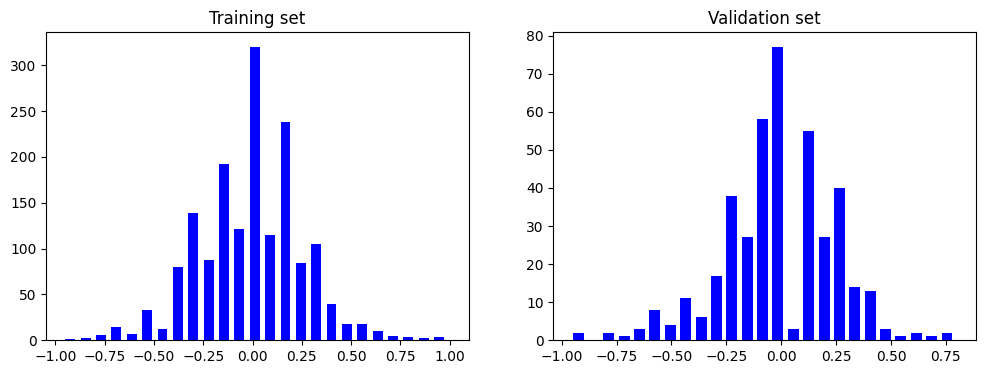

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = 'blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = 'blue')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:140,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed image')

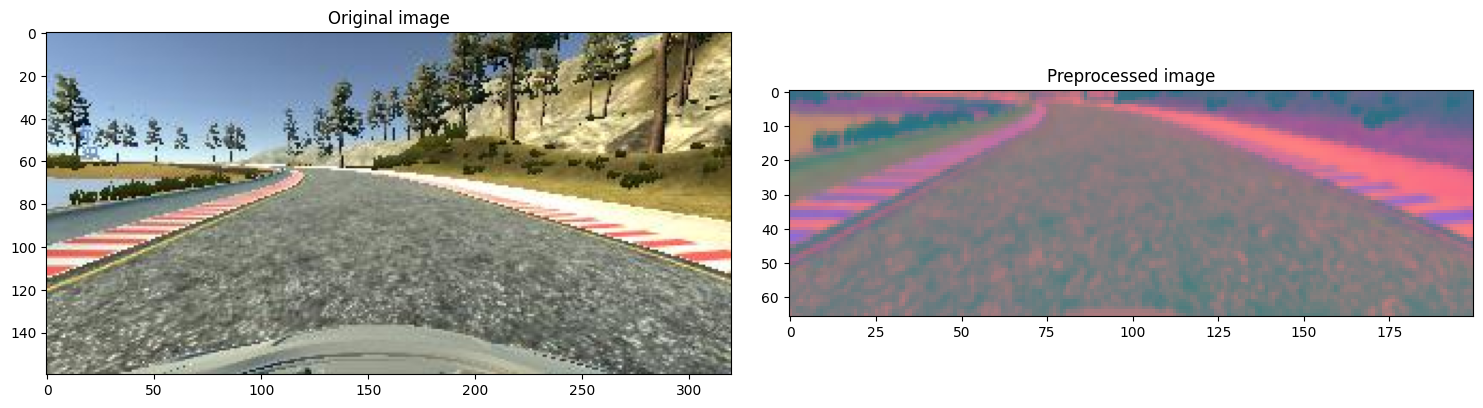

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1660, 66, 200, 3)


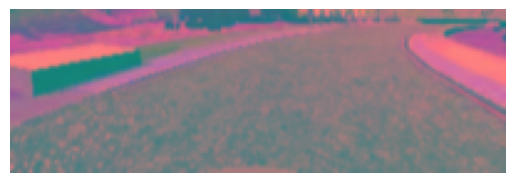

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_6 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=150, verbose=1, shuffle=1)

Epoch 1/30
12/12 [==============================] - 1s 65ms/step - loss: 0.4339 - val_loss: 0.1008
Epoch 2/30
12/12 [==============================] - 0s 35ms/step - loss: 0.1412 - val_loss: 0.0596
Epoch 3/30
12/12 [==============================] - 0s 36ms/step - loss: 0.0963 - val_loss: 0.0565
Epoch 4/30
12/12 [==============================] - 0s 34ms/step - loss: 0.0772 - val_loss: 0.0525
Epoch 5/30
12/12 [==============================] - 0s 33ms/step - loss: 0.0682 - val_loss: 0.0503
Epoch 6/30
12/12 [==============================] - 0s 34ms/step - loss: 0.0630 - val_loss: 0.0469
Epoch 7/30
12/12 [==============================] - 0s 35ms/step - loss: 0.0585 - val_loss: 0.0447
Epoch 8/30
12/12 [==============================] - 0s 35ms/step - loss: 0.0542 - val_loss: 0.0423
Epoch 9/30
12/12 [==============================] - 0s 35ms/step - loss: 0.0541 - val_loss: 0.0406
Epoch 10/30
12/12 [==============================] - 0s 35ms/step - loss: 0.0541 - val_loss: 0.0399
Epoch 11/

Text(0.5, 0, 'Epoch')

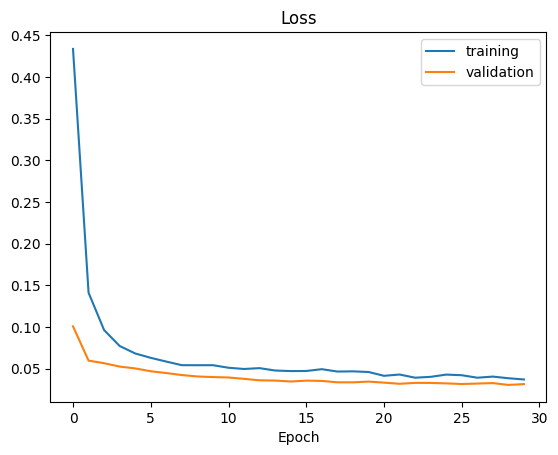

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>